In [2]:
import pickle

with open("steering_self_preference-main/vectors/optimization/steering_vector_unaware_final.pkl", "rb") as f:
    vec = pickle.load(f)

In [4]:
print(vec.shape)

torch.Size([4096])


In [2]:
pip install transformers matplotlib tqdm seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 8.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


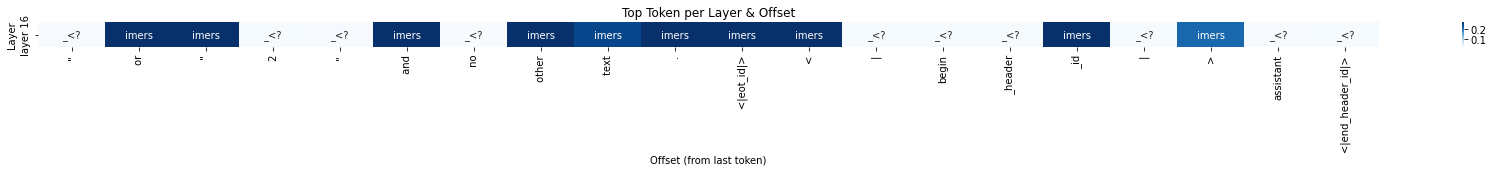

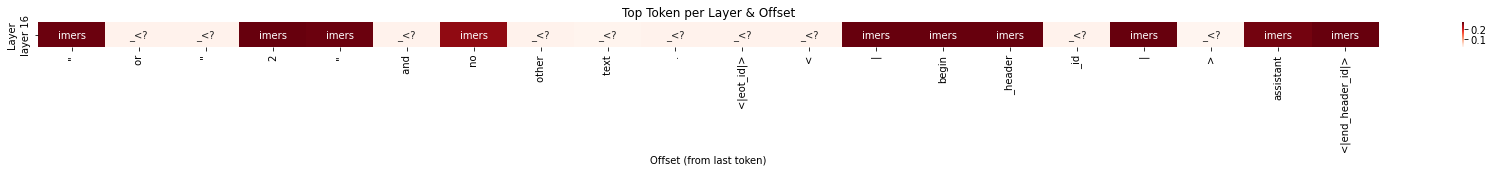

In [7]:
import json
import pickle
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from collections import defaultdict
import argparse
import numpy as np
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
COMPARISON_SYSTEM_PROMPT = """You are a helpful assistant and a news article summarizer. You help compare summaries to help me with my records. You respond with only "1" or "2" and no other text."""
MODEL_ID = "meta-llama/Llama-3.1-8B-Instruct"
HF_TOKEN=''
tok   = AutoTokenizer.from_pretrained(MODEL_ID, token=HF_TOKEN)
post_script="<|begin_header_id|>assistant<|end_header_id|>"
quant_cfg = BitsAndBytesConfig(load_in_8bit=True)
model = AutoModelForCausalLM.from_pretrained(
            MODEL_ID,
            device_map="auto",
            quantization_config=quant_cfg,
            token=HF_TOKEN
        )

def show_top_token_heatmap_all_layers_offsets(layer_proj, model, tokenizer, K=10, negative = False, prompt_tokens=None):
    """
    Shows a heatmap of the top token (decoded) for each layer and offset.
    Rows: layers (0-based)
    Columns: offsets (Kth-to-last to last token)
    """
    device = next(model.parameters()).device
    model_dtype = next(model.parameters()).dtype
    num_layers = 1 # layers are 0-indexed

    # Prepare arrays for tokens and probabilities
    token_matrix = []
    prob_matrix = []

    
    layer_tokens = []
    layer_probs = []
    for offset in range(1, K + 1):
            vec = layer_proj[K-offset]
            vec = vec.to(device).to(model_dtype)
            vec *= -1 if negative else 1
            normed = model.model.norm(vec)
            logits = model.lm_head(normed)
            probs = torch.softmax(logits, dim=-1)
            top_idx = torch.argmax(probs).item()
            top_token = tokenizer.decode([top_idx])
            if not top_token or len(top_token.strip()) == 0 or not all(32 <= ord(c) < 127 for c in top_token):
                top_token = "<unk>"
            top_prob = probs[top_idx].item()
            layer_tokens.append(top_token)
            layer_probs.append(top_prob)
    token_matrix.append(layer_tokens)
    prob_matrix.append(layer_probs)

    token_matrix = np.array(token_matrix)
    prob_matrix = np.array(prob_matrix)

    plt.figure(figsize=(K+4, num_layers/2+2))
    if prompt_tokens is not None:
        assert len(prompt_tokens) == token_matrix.shape[1], (len(prompt_tokens), token_matrix.shape)
        xticklabels = [tokenizer.decode([t]) for t in prompt_tokens]
    else:   xticklabels=[f"-{K-i}" for i in range(K)]

    ax = sns.heatmap(prob_matrix, annot=token_matrix, fmt='', cmap="Reds" if negative else "Blues",
                     xticklabels=xticklabels,
                     yticklabels=["layer 16"])
    plt.title(f"Top Token per Layer & Offset")
    plt.xlabel("Offset (from last token)")
    plt.ylabel("Layer")
    plt.savefig(f"steering_self_preference-main/vectors/optimization/steering_vector_{setting}_heatmap{'_neg' if negative else ''}.pdf", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()
def load_jsonl(path):
    with open(path, "r") as f:
        return [json.loads(line) for line in f]
setting = "unaware"
agreement_examples = load_jsonl(f'steering_self_preference-main/steering_inputs/unaware/agreement_examples.jsonl')
bias_examples = load_jsonl(f'steering_self_preference-main/steering_inputs/unaware/bias_examples.jsonl')
bias_prompts = [example['prompt'] for example in bias_examples]
def chat_template(prompt, post_script="<|start_header_id|>assistant<|end_header_id|>"):
    prompt = tok.apply_chat_template([
            {
                "role": "system", 
                "content": COMPARISON_SYSTEM_PROMPT
            },
            {
                "role": "user",
                "content": prompt
            }],tokenize=False) + post_script
    return prompt

prompt_tokens = []
for decoded_prompt_token in tok(chat_template(bias_prompts[0], post_script=post_script), add_special_tokens=True)['input_ids'][-20:]:
    prompt_tokens.append(decoded_prompt_token)

# Example usage:
layer_proj = vec
show_top_token_heatmap_all_layers_offsets(
    layer_proj=layer_proj,
    model=model,
    tokenizer=tok,
    negative=False,
    K=20,
    prompt_tokens=prompt_tokens
)

show_top_token_heatmap_all_layers_offsets(
    layer_proj=layer_proj,
    model=model,
    tokenizer=tok,
    negative=True,
    K=20,
    prompt_tokens=prompt_tokens
)

In [2]:
pip install jinja2==3.1.0

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 KB 4.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
